# Project: ReID

## Introduction

We wanted to reidentify a person, given some samples of the dataset. The idea is to learn the main features of the person in order to distinguish him/her from other people.



The first thing that we did was to import libraries.

In [1]:
from sklearn.svm import SVC
from sklearn.svm import SVR

from load_data import DataLoader
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import tqdm
import config
import math
import matplotlib.pyplot as plt
import scikitplot as skplt
from utils import filter_and_split_dataset



The first thing that we did was to read the dataset and extract the information that we need in order to recognize people:

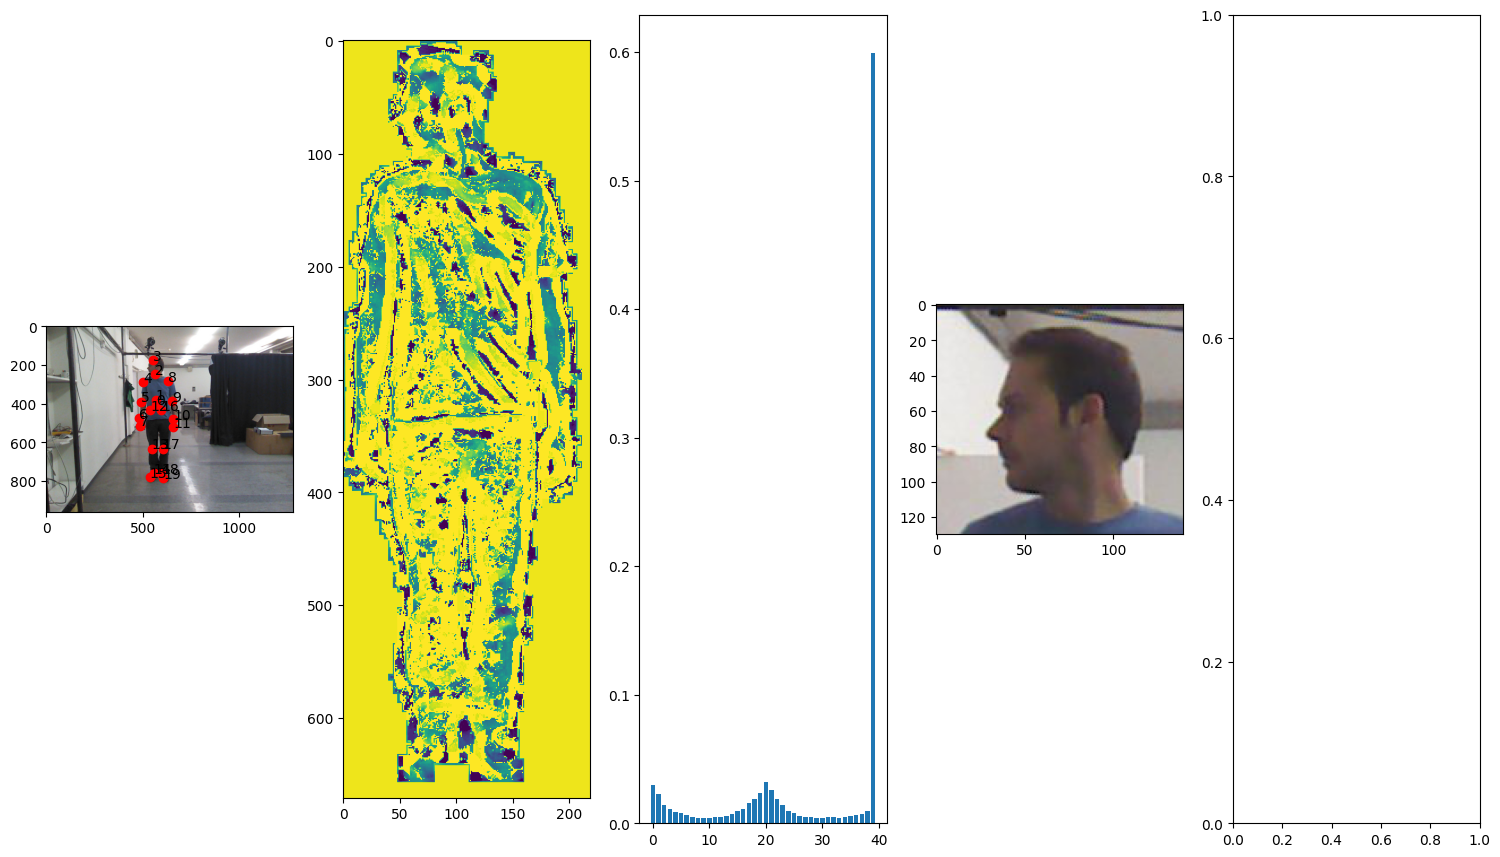

In [2]:
d = DataLoader()
d.read_dataset()
d.shuffle_videos()
d.display_dataset()

metrics = []


The next thing to do was to design the learning setting. The first and easiest idea was to test a variety of classifiers, and see which works better for our features.

We tested different classifiers:

In [3]:
def test_model(name, model_skel, model_clothes, model_face, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test):
    global metrics
    model_skel.fit(X_skel, y_train)
    model_clothes.fit(X_clothes, y_train)
    model_face.fit(X_face, y_face)


    print("-" * 10)
    print("|", name, "|")
    # Test
    print("-" * 10)
    skel_pred = model_skel.predict(X_skel_test)
    print(classification_report(y_test, skel_pred))
    print("-" * 10)
    clothes_pred = model_clothes.predict(X_clothes_test)
    print(classification_report(y_test, clothes_pred))
    print("-" * 10)
    face_pred = model_face.predict(X_face_test)
    print(classification_report(y_face_test, face_pred))

    skel_pred_roc = model_skel.predict_proba(X_skel_test)
    clothes_pred_roc = model_clothes.predict_proba(X_clothes_test)
    face_pred_roc = model_face.predict_proba(X_face_test)

    # skplt.metrics.plot_roc(y_test, skel_pred_roc, title= name.split("_")
    #                        [-1].split(".")[-1] + " skel" + " ROC", plot_micro=True, plot_macro=True, classes_to_plot=[
    #                        0, 1], ax=None, figsize=None)
    # plt.show()
    # skplt.metrics.plot_roc(y_test, clothes_pred_roc, title= name.split("_")
    #                         [-1].split(".")[-1] + " clothes" + " ROC", plot_micro=True, plot_macro=True, classes_to_plot=[
    #                         0, 1], ax=None, figsize=None)
    # plt.show()
    # skplt.metrics.plot_roc(y_face_test, face_pred_roc, title= name.split("_")
    #                         [-1].split(".")[-1] + " face" + " ROC", plot_micro=True, plot_macro=True, classes_to_plot=[
    #                         0, 1], ax=None, figsize=None)
    # plt.show()
    

    # skplt.metrics.plot_confusion_matrix(
    #     y_test, skel_pred, title=name.split("_")[-1].split(".")[-1] + " skel" + " Confusion Matrix", normalize=True)
    # plt.show()
    # skplt.metrics.plot_confusion_matrix(
    #     y_test, clothes_pred, title=name.split("_")[-1].split(".")[-1] + " clothes" + " Confusion Matrix", normalize=True)
    # plt.show()
    # skplt.metrics.plot_confusion_matrix(
    #     y_face_test, face_pred, title=name.split("_")[-1].split(".")[-1] + " face" + " Confusion Matrix", normalize=True)
    # plt.show()

    metrics.append([name.split("_")[-1].split(".")[-1], y_test, y_face_test, skel_pred, clothes_pred, face_pred, skel_pred_roc, clothes_pred_roc, face_pred_roc])


In [4]:
X = np.load(config.SAMPLED_PATH + "sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "sample_0_y.npy")
X_skel, X_clothes, X_face, _, ___, ____, y_train, _____, y_face, ______ = filter_and_split_dataset(X, y)


X = np.load(config.SAMPLED_PATH + "sample_1_X.npy")
y = np.load(config.SAMPLED_PATH + "sample_1_y.npy")
X_skel_test, X_clothes_test, X_face_test, _, __, ___, y_test, ____, y_face_test, _____ = filter_and_split_dataset(X, y)


NameError: name 'ax_det' is not defined

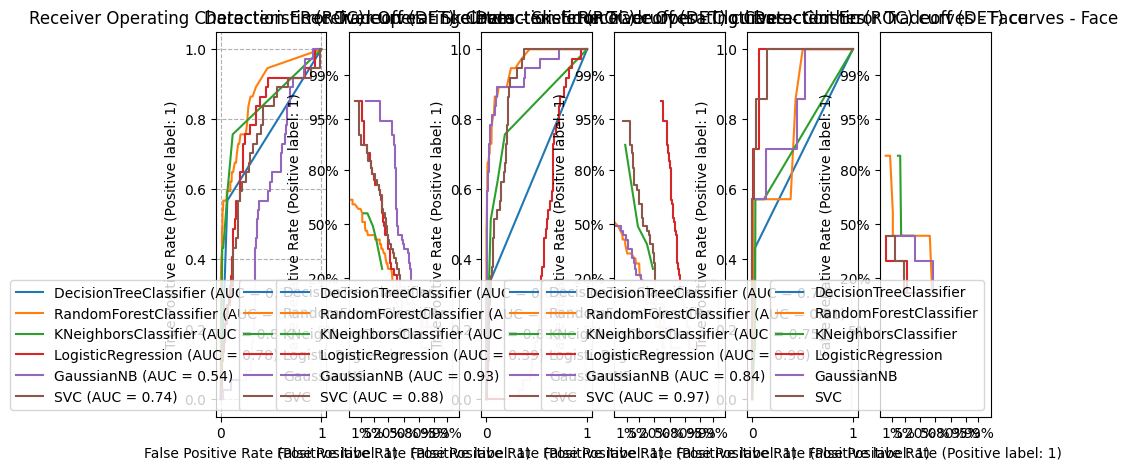

In [5]:

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

classifiers_skel = {
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

classifiers_clothes = {
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

classifiers_face = {
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}


fig, (ax_roc_skel, ax_det_skel, ax_roc_clothes, ax_det_clothes, ax_roc_face, ax_det_face) = plt.subplots(1, 6, figsize=(10, 5))

for name, model in classifiers_skel.items():
    model.fit(X_skel, y_train)
    RocCurveDisplay.from_estimator(model, X_skel_test, y_test, ax=ax_roc_skel, name=name)
    DetCurveDisplay.from_estimator(model, X_skel_test, y_test, ax=ax_det_skel, name=name)

for name, model in classifiers_clothes.items():
    model.fit(X_clothes, y_train)
    RocCurveDisplay.from_estimator(model, X_clothes_test, y_test, ax=ax_roc_clothes, name=name)
    DetCurveDisplay.from_estimator(model, X_clothes_test, y_test, ax=ax_det_clothes, name=name)

for name, model in classifiers_face.items():
    model.fit(X_face, y_face)
    RocCurveDisplay.from_estimator(model, X_face_test, y_face_test, ax=ax_roc_face, name=name)
    DetCurveDisplay.from_estimator(model, X_face_test, y_face_test, ax=ax_det_face, name=name)


ax_roc_skel.set_title("Receiver Operating Characteristic (ROC) curves - Skeleton")
ax_det_skel.set_title("Detection Error Tradeoff (DET) curves - Skeleton")
ax_roc_clothes.set_title("Receiver Operating Characteristic (ROC) curves - Clothes")
ax_det_clothes.set_title("Detection Error Tradeoff (DET) curves - Clothes")
ax_roc_face.set_title("Receiver Operating Characteristic (ROC) curves - Face")
ax_det_face.set_title("Detection Error Tradeoff (DET) curves - Face")


ax_roc_skel.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

### Decision Tree

In [ ]:
m1 = DecisionTreeClassifier()
m2 = DecisionTreeClassifier()
m3 = DecisionTreeClassifier()
test_model("DecisionTreeClassifier", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test)

----------
| DecisionTreeClassifier |
----------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       750
           1       0.33      0.62      0.43        37

    accuracy                           0.92       787
   macro avg       0.66      0.78      0.70       787
weighted avg       0.95      0.92      0.93       787

----------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       750
           1       0.62      0.62      0.62        37

    accuracy                           0.96       787
   macro avg       0.80      0.80      0.80       787
weighted avg       0.96      0.96      0.96       787

----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.75      0.75      0.75         4

    accuracy                           0.99       296
   macro avg       0.87      0.87      0.87       296
wei

### Random Forest

In [ ]:
#  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}
m1 = RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 42)
m2 = RandomForestClassifier()
m3 = RandomForestClassifier()
test_model("RandomForestClassifier", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test)

----------
| RandomForestClassifier |
----------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       750
           1       0.77      0.62      0.69        37

    accuracy                           0.97       787
   macro avg       0.87      0.81      0.84       787
weighted avg       0.97      0.97      0.97       787

----------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       750
           1       1.00      0.43      0.60        37

    accuracy                           0.97       787
   macro avg       0.99      0.72      0.79       787
weighted avg       0.97      0.97      0.97       787

----------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       292
           1       1.00      0.25      0.40         4

    accuracy                           0.99       296
   macro avg       0.99      0.62      0.70       296
wei

### KNeighbors

In [ ]:
m1 = KNeighborsClassifier()
m2 = KNeighborsClassifier()
m3 = KNeighborsClassifier()
test_model("KNeighborsClassifier", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test)

----------
| KNeighborsClassifier |
----------
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       750
           1       0.47      0.59      0.52        37

    accuracy                           0.95       787
   macro avg       0.72      0.78      0.75       787
weighted avg       0.96      0.95      0.95       787

----------
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       750
           1       0.36      0.51      0.42        37

    accuracy                           0.93       787
   macro avg       0.67      0.73      0.69       787
weighted avg       0.95      0.93      0.94       787

----------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       292
           1       0.25      0.25      0.25         4

    accuracy                           0.98       296
   macro avg       0.62      0.62      0.62       296
weigh

### Logistic Regession

In [ ]:
m1 = LogisticRegression(solver="liblinear", max_iter=10000)
m2 = LogisticRegression(solver="liblinear", max_iter=10000)
m3 = LogisticRegression(solver="liblinear", max_iter=10000)
test_model("LogisticRegression", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test,  X_face_test, y_train, y_test, y_face, y_face_test)

----------
| LogisticRegression |
----------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       750
           1       0.00      0.00      0.00        37

    accuracy                           0.95       787
   macro avg       0.48      0.50      0.49       787
weighted avg       0.91      0.95      0.93       787

----------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       750
           1       0.00      0.00      0.00        37

    accuracy                           0.95       787
   macro avg       0.48      0.50      0.49       787
weighted avg       0.91      0.95      0.93       787

----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.75      0.75      0.75         4

    accuracy                           0.99       296
   macro avg       0.87      0.87      0.87       296
weighte

/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Gaussian NB

In [ ]:
m1 = GaussianNB()
m2 = GaussianNB()
m3 = GaussianNB()
test_model("GaussianNB", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test,  X_face_test, y_train, y_test, y_face, y_face_test)

----------
| GaussianNB |
----------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       750
           1       0.00      0.00      0.00        37

    accuracy                           0.95       787
   macro avg       0.48      0.50      0.49       787
weighted avg       0.91      0.95      0.93       787

----------
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       750
           1       0.19      0.89      0.31        37

    accuracy                           0.82       787
   macro avg       0.59      0.85      0.60       787
weighted avg       0.96      0.82      0.87       787

----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.75      0.75      0.75         4

    accuracy                           0.99       296
   macro avg       0.87      0.87      0.87       296
weighted avg   

/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVC

In [ ]:
m1 = SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42)
m2 = SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42)
m3 = SVC(C = 1, kernel = "rbf", degree = 3, gamma = "auto", probability = True, random_state = 2, decision_function_shape = "ovo")
test_model("SVC", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test)

----------
| SVC |
----------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       750
           1       0.00      0.00      0.00        37

    accuracy                           0.95       787
   macro avg       0.48      0.50      0.49       787
weighted avg       0.91      0.95      0.93       787

----------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       750
           1       0.00      0.00      0.00        37

    accuracy                           0.95       787
   macro avg       0.48      0.50      0.49       787
weighted avg       0.91      0.95      0.93       787

----------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       292
           1       0.25      0.75      0.38         4

    accuracy                           0.97       296
   macro avg       0.62      0.86      0.68       296
weighted avg       0.9

/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/si

## Model Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def fit_models(models, X_train, y_train):
    for name, model in models.items():
        model.fit(X_train, y_train.ravel())
        print(name, 'trained.')
    return

def evaluate_models(models, X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred,zero_division=0))
        cv_accuracy = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='accuracy')
        cv_f1_macro = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='f1_macro')
        print(cross_val_score(model, X_test, y_test, scoring='accuracy'))
        print("Accuracy: %0.4f (+/- %0.4f)" % (cv_accuracy.mean(), cv_accuracy.std() * 2))
        print(cross_val_score(model, X_test, y_test, scoring='f1_macro'))
        print("f1-score: %0.4f (+/- %0.4f)" % (cv_f1_macro.mean(), cv_f1_macro.std() * 2))
        #plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)



        print('------------------------------------')
    return  

def tune_model(model, param_grid, scoring, x_train, y_train, grid_jobs):
    print('tuning...')
    clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, verbose=1, n_jobs=grid_jobs)
    clf.fit(x_train, y_train.ravel())
    print('done')
    print()
    print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
    best_params = clf.best_params_.copy()
    return best_params
 


SVM_param_grid = {
    'C': [0.5, 1],
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'decision_function_shape': ['ovo', 'ovr'],
    'random_state': [2,42]
}

RF_param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [2,42]
}

Gauss_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}



best_accuracy_params_skel = tune_model(RandomForestClassifier(), RF_param_grid, 'accuracy', X_skel, y_train, -1)

best_f1macro_params_skel = tune_model(RandomForestClassifier(), RF_param_grid, 'f1_macro',  X_skel, y_train, -1)

# best_accuracy_params_clothes = tune_model(GaussianNB(), Gauss_param_grid, 'accuracy', X_clothes, y_train, -1)

# best_f1macro_params_clothes = tune_model(GaussianNB(), Gauss_param_grid, 'f1_macro',  X_clothes, y_train, -1)
best_accuracy_params_clothes = tune_model(RandomForestClassifier(), RF_param_grid, 'accuracy', X_clothes, y_train, -1)

best_f1macro_params_clothes = tune_model(RandomForestClassifier(), RF_param_grid, 'f1_macro',  X_clothes, y_train, -1)

best_accuracy_params_face = tune_model(SVC(), SVM_param_grid, 'accuracy', X_face, y_face, -1)

best_f1macro_params_face = tune_model(SVC(), SVM_param_grid, 'f1_macro',  X_face, y_face, -1)



tuned_models_skel = {
    'RF_Skeleton_accuracy': RandomForestClassifier(**best_accuracy_params_skel),
    'RF_Skeleton_f1macro': RandomForestClassifier(**best_f1macro_params_skel)
}

tuned_models_clothes = {
    # 'GNB_accuracy': GaussianNB(**best_accuracy_params_clothes),
    # 'GNB_f1macro': GaussianNB(**best_f1macro_params_clothes)
    'RF_Clothes_accuracy': RandomForestClassifier(**best_accuracy_params_clothes),
    'RF_Clothes_f1macro': RandomForestClassifier(**best_f1macro_params_clothes)
}

tuned_models_face = {
    'SVM_Face_accuracy': SVC(**best_accuracy_params_face),
    'SVM_Face_f1macro': SVC(**best_f1macro_params_face)
}


fit_models(tuned_models_skel, X_skel, y_train)
fit_models(tuned_models_clothes, X_clothes, y_train)
fit_models(tuned_models_face, X_face, y_face)

evaluate_models(tuned_models_skel, X_skel, y_train)
evaluate_models(tuned_models_clothes, X_clothes, y_train)
evaluate_models(tuned_models_face, X_face, y_face)

tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
done

Best: 0.980948 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}
tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
done

Best: 0.867429 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}
tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
done

Best: 0.977127 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}
tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
done

Best: 0.827563 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators':

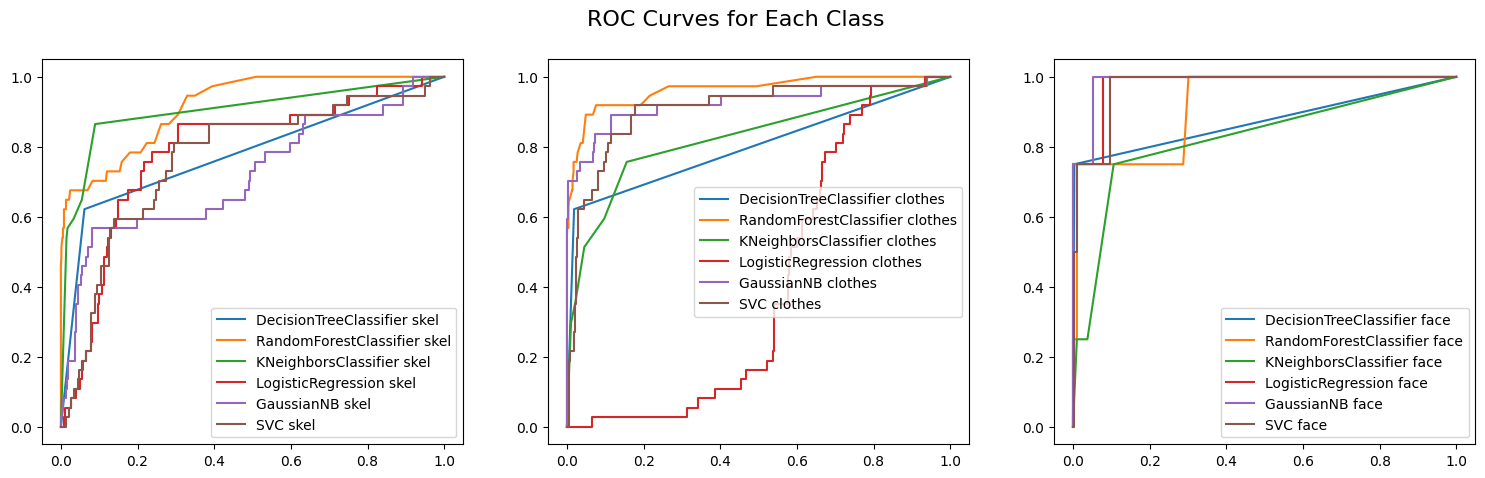

In [ ]:
# PLOT
    # Iterate through each set of data in the list

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18.5, 5)
fig.suptitle('ROC Curves for Each Class', fontsize=16)


for data in metrics:
    # Assign variables to the data in the list
    label, y_test, y_face_test, skel_pred_roc, clothes_pred_roc, face_pred_roc = data[0], data[1], data[2], data[6][:, 1], data[7][:, 1], data[8][:, 1]

    # Compute the false positive rate and true positive rate for each class
    fpr_skel, tpr_skel, thresholds_skel = roc_curve(y_test, skel_pred_roc)
    fpr_clothes, tpr_clothes, thresholds_clothes = roc_curve(y_test, clothes_pred_roc)
    fpr_face, tpr_face, thresholds_face = roc_curve(y_face_test, face_pred_roc)


    # Plot the ROC curve for each class
    # fig_skels, ax_skels = plt.subplots()
    ax[0].plot(fpr_skel, tpr_skel, label=label + ' skel')
    ax[0].legend()
    
    ax[1].plot(fpr_clothes, tpr_clothes, label=label + ' clothes')
    ax[1].legend()

    ax[2].plot(fpr_face, tpr_face, label=label + ' face')
    ax[2].legend()


## Regression

We also thought that it was possible to learn a "latent space" that ensambles that person's features. The idea is that a regressor can learn how to optimize the outpot of a linear combination so that features from the person that we want to re-identify will output a low value (0) while the other people will output an higher value (1).

Given that, we tested some regressors in order to learn the features of a person.

In [ ]:
X_logistic, y_logistc, _ = d.sample_dataset(video=vid, return_images=False)
X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test = filter_and_split_dataset(X, y)
X_skel_logistic, X_clothes_logistic, X_face_logistic, X_skel_test_logistic, X_clothes_test_logistic, X_face_test_logistic, y_train_logistic, y_test_logistic, y_face_logistic, y_face_test_logistic = filter_and_split_dataset(X_logistic, y_logistc)
c_svr = 0

def test_regression(name, model_skel, model_clothes, model_face, 
        X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test):


params_smr = [(2, "poly"), (3, "poly"), (2, "linear")]
for name, m in regressors:
model_skel = model_clothes = model_face = None
if m is Pipeline:
    model_skel, model_clothes, model_face = m([("poly", PolynomialFeatures()), ("Regression", LinearRegression())]), m([("poly", PolynomialFeatures()), ("Regression", LinearRegression())]), m([("poly", PolynomialFeatures()), ("Regression", LinearRegression())])
elif m is SVR:
    model_skel, model_clothes, model_face = m(degree=params_smr[c_svr][0], kernel=params_smr[c_svr][1]), m(degree=params_smr[c_svr][0], kernel=params_smr[c_svr][1]), m(degree=params_smr[c_svr][0], kernel=params_smr[c_svr][1])
    c_svr += 1
else:
    model_skel, model_clothes, model_face = m(), m(), m()

if m is LogisticRegression:
    model_skel.fit(X_skel, y_train, max_iter=10000)
    model_clothes.fit(X_clothes, y_train, max_iter=10000)
    model_face.fit(X_face, y_train, max_iter=10000)
else:
    model_skel.fit(X_skel, y_train)
    model_clothes.fit(X_clothes, y_train)
    model_face.fit(X_face, y_face)

# Train the logistic regressor
log_reg_skel, log_reg_clothes, log_reg_face = LogisticRegression(), LogisticRegression(), LogisticRegression()
log_reg_skel.fit(model_skel.predict(X_skel_logistic).reshape(-1, 1), y_train_logistic)
log_reg_clothes.fit(model_clothes.predict(X_clothes_logistic).reshape(-1, 1), y_train_logistic)
log_reg_face.fit(model_face.predict(X_face_logistic).reshape(-1, 1), y_face_logistic)


# Test
print("-" * 10)
print("|", name, "|")
print("-" * 10)
print("| skel |")
skel_pred = model_skel.predict(X_skel_test)
log_skel_pred = log_reg_skel.predict(skel_pred.reshape(-1, 1))

print(classification_report(y_test, log_skel_pred))
print(mean_absolute_error(y_test, skel_pred))
print(mean_squared_error(y_test, skel_pred))


print("| clothes |")
clotehs_pred = model_clothes.predict(X_clothes_test)
log_clotehs_pred = log_reg_clothes.predict(clotehs_pred.reshape(-1, 1))

print(classification_report(y_test, log_clotehs_pred))
print(mean_absolute_error(y_test, clotehs_pred))
print(mean_squared_error(y_test, clotehs_pred))


print("| face |")
face_pred = model_face.predict(X_face_test)
log_face_pred = log_reg_face.predict(face_pred.reshape(-1, 1))

print(classification_report(y_face_test, log_face_pred))
print(mean_absolute_error(y_face_test, face_pred))
print(mean_squared_error(y_face_test, face_pred))

plt.plot(y_test, clotehs_pred, 'o')
plt.show()

plt.plot(y_test, skel_pred, 'o')
plt.show()

Best paramatri